In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data=pd.read_csv(r"C:\Users\yash-\Downloads\multi_classification_train.csv")

In [4]:
d_np=data.to_numpy()
d_np.shape

(48000, 22)

In [5]:
X=d_np[:,1:21]
y=d_np[:,21]
X_mean=np.mean(X)
X_std=np.std(X)
X_normalize=(X-X_mean)/X_std

In [36]:
def relu(X):
    return np.maximum(0,X)
def softmax(X):
    x_max=np.max(X,axis=-1,keepdims=True)
    return np.exp(X-x_max)/np.sum(np.exp(X-x_max),axis=-1,keepdims=True)
    
def tanh(X):
    return np.tanh(X)
def sigmoid(X):
  return 1/(1+np.exp(-X))
def der_relu(X):
    return X>0
def der_sigmoid(X):
    return 1/(1+np.exp(-X))**2
def der_tanh(X_):
    X=tanh(X_)
    return(1-np.power(X,2))


In [7]:
def init(layer_dims):
    L=len(layer_dims)
    parameters={}
    
    for l in range(1,L):
        np.random.seed(1234)
        parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.001
        parameters["B"+str(l)]=np.zeros((layer_dims[l],1))
    return parameters

In [8]:
def forward_prop(X,parameters):
    L=(len(parameters)//2)
    forward={}
    forward["A0"]=X
    
    for l in range(1,L):
        forward["Z"+str(l)]=np.dot(parameters["W"+str(l)],forward["A"+str(l-1)])+ parameters["B"+str(l)]
        forward["A"+str(l)]=tanh(forward["Z"+str(l)]) 
    forward["Z"+str(L)]=np.dot (parameters["W"+str(L)],forward["A"+str(L-1)])+ parameters["B"+str(L)]
    forward["A"+str(L)]=softmax(forward["Z"+str(L)])
    
    return forward["A"+str(L)],forward

In [9]:
def cost_function(AL,y):
    m=y.shape[0]
    cost= (-1/m)*np.sum(y*np.log(AL))
    return cost

In [10]:
def backward_prop(AL,y,parameters,forwards):
    
    grads={}
    L=len(parameters)//2
    m=y.shape[0]
    grads["dZ"+str(L)]=AL-y
    grads["dW"+str(L)]=(1/m)*np.dot((grads["dZ"+str(L)]),forwards["A"+str(L-1)].T)
    grads["dB"+str(L)]=(1/m)*np.sum(grads["dZ"+str(L)],axis=1,keepdims=True)
    
    for l in reversed (range(1,L)):
        grads["dZ"+str(l)]=np.dot(parameters["W"+str(l+1)].T,grads["dZ"+str(l+1)])+der_tanh(forwards["A"+str(l)])
        grads["dW"+str(l)]=(1/m)*np.dot(grads["dZ"+str(l)],forwards["A"+str(l-1)].T)
        grads["dB"+str(l)]=(1/m)*np.sum(grads["dZ"+str(l)],axis=1,keepdims=True)
    
        
    return grads
    

In [11]:
def update_parameters(y,parameters,grads,lr,lambd):
    L=len(parameters)//2
    m=y.shape[0]
    for l in range(1,L+1):
        parameters["W"+str(l)]= parameters["W"+str(l)]*(1-lr*lambd/m)-lr*grads["dW"+str(l)]
        parameters["B"+str(l)]-= lr*grads["dB"+str(l)]
    return parameters

In [12]:
def accuracy(X,y,parameters):
    preds,_=forward_prop(X,parameters)
    print("Before argmax Predictions are :",preds)
    m=y.size
    preds=np.argmax(preds,axis=0)
    print("Predictions are :",preds)
    return np.sum(y==preds)/m

In [13]:
data_train=X_normalize[0:40000,:].T
y_train=y[0:40000]
data_test=X_normalize[40001:,:].T
y_test=y[40001:]

In [14]:
def calculate_precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    
    if predicted_positives == 0:
        return 0  # Avoid division by zero
    return true_positives / predicted_positives
def calculate_recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    if actual_positives == 0:
        return 0  # Avoid division by zero
    return true_positives / actual_positives
def Calculate_f1(y_true, y_pred):
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)
def Calculate_f1_multiclass(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    f1_scores = []

    for class_label in range(num_classes):
        y_true_binary = (y_true == class_label).astype(int)
        y_pred_binary = (y_pred == class_label).astype(int)
        f1 = Calculate_f1(y_true_binary, y_pred_binary)
        f1_scores.append(f1)
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        for class_label in range(num_classes):
             true_positives += np.sum((y_true == class_label) & (y_pred == class_label))
             false_positives += np.sum((y_true != class_label) & (y_pred == class_label))
             false_negatives += np.sum((y_true == class_label) & (y_pred != class_label))
        precision = true_positives/(true_positives+false_positives)
        recall = true_positives/(true_positives+false_negatives)
        return 2*precision*recall/(precision+recall)

In [34]:
def model(X,y,layer_dims,lr,iters):
    parameters=init(layer_dims)
    cost_list=[]
    for i in range(iters):
        AL,forward_p=forward_prop(X,parameters)
        cost=cost_function(AL,y)
        grads=backward_prop(AL,y,parameters,forward_p)
        parameters=update_parameters(y,parameters,grads,lr,lambd=.0001) 
        cost_list.append(cost)
    print("Cost is",cost)

    return parameters,cost_list

Cost is 108.50246626929396
Predictions are : [3 2 2 ... 3 3 3]
The F1 score of multilabel model is 0.361670208776097
LEARNING CURVE


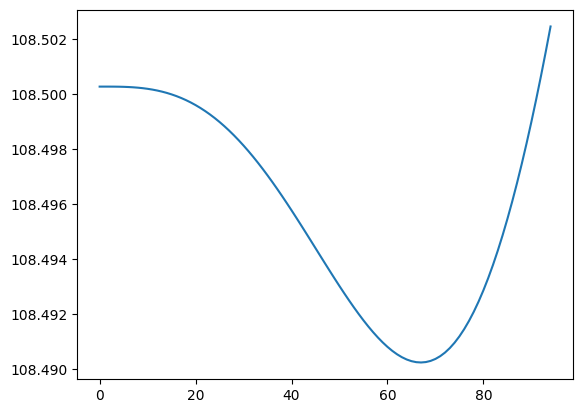

In [37]:
layer_dims=[data_train.shape[0],14,5]
iters=95
Parameters,Cost_list=model(data_train,y_train,layer_dims,lr=0.001,iters=iters)
def Prediction(X,parameters):
    preds,_=forward_prop(X,parameters)
    preds=np.argmax(preds,axis=0)
    return preds
preds=Prediction(data_test,Parameters)
print("Predictions are :",preds)
print("The F1 score of multilabel model is",Calculate_f1_multiclass(y_test,preds))

print("LEARNING CURVE")
t=np.arange(0,iters)
plt.plot(t,Cost_list)
plt.show()
